In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

plt.rcParams["legend.fontsize"] = "xx-small"

rc = {
    "axes.axisbelow": True,
    "axes.linewidth": 1.0,
    "axes.labelsize": "x-small",
    "axes.titlesize": "x-small",
    "figure.dpi": 150,
    "figure.figsize": (3.2, 3.2),
    "font.size": 12.0,
    "legend.fontsize": "xx-small",
    "lines.linewidth": 1.0,
    "savefig.transparent": True,
    "xtick.labelsize": "xx-small",
    "xtick.major.width": 1.0,
    "ytick.labelsize": "xx-small",
    "ytick.major.width": 1.0,
    "font.family": ["serif"],
    # 'text.usetex': True,
    # 'text.latex.preamble': r"\usepackage{amsfonts}",
}

plt.rcParams.update(rc)

In [2]:
df = pd.read_csv(
    "~/ceph/lola/results/rayleigh_benard/stats.csv",
    names=[
        "run",
        "target",
        "compression",
        "method",
        "settings",
        "guidance",
        "context",
        "overlap",
        "speed",
        "split",
        "index",
        "start",
        "seed",
        "field",
        "time",
        "auto_encoded",
        "m1",
        "m2",
        "spread",
        "rmse",
        "nrmse",
        "vrmse",
        "re_total",
        "rmse_p_low",
        "rmse_c_low",
        "rmse_p_mid",
        "rmse_c_mid",
        "rmse_p_high",
        "rmse_c_high",
        "rmse_p_sub",
        "rmse_c_sub",
        "rayleigh",
        "prandtl",
        "bc00",
        "bc01",
        "bc10",
        "bc11",
    ],
    dtype={"settings": str, "guidance": str, "compression": int},
)

df = df[~df["auto_encoded"]]
df = df[df["time"] > 0]
df = df[df["start"] == 32]
df = df.merge(
    pd.DataFrame({
        "field": [0, 1, 2, 3],
        "std_global": [0.25, 0.15, 0.20, 0.20],
    })
)


def horizon(t):
    if t < 20:
        return "1:20"
    elif t < 60:
        return "21:60"
    else:
        return "61:200"


df["horizon"] = df["time"].apply(horizon)
df["std_instant"] = np.sqrt(df["m2"] - df["m1"] ** 2)
df["coverage"] = (df["spread"] + 1e-3) / (df["rmse"] + 1e-3)
df.loc[df["method"] == "surrogate", "coverage"] = 0.0

To aggregate the metrics of different fields, we use a weighted average where the weights are the fields' instantaneous std, relative to the fields' global std.

In [3]:
weight = df["std_instant"] / df["std_global"]


def weighted_mean(x):
    w = weight[x.index]
    return np.mean(x * w) / np.mean(w)

## Plots

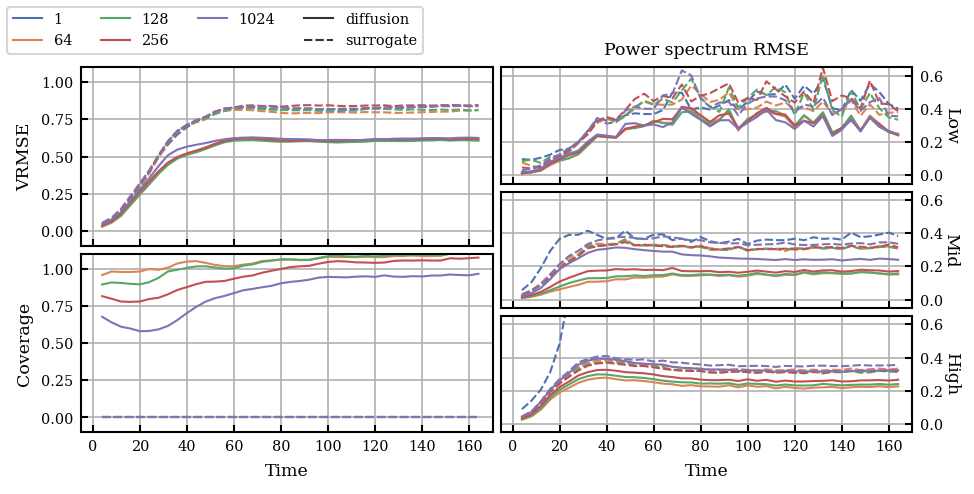

In [4]:
fig, axs = plt.subplot_mosaic(
    [
        [0, 2],
        [0, 2],
        [0, 3],
        [1, 3],
        [1, 4],
        [1, 4],
    ],
    figsize=(6.4, 3.2),
    sharex=True,
    sharey=False,
)

for i, metric in enumerate(["VRMSE", "Coverage"]):
    ax = sb.lineplot(
        df,
        x="time",
        y=metric.lower(),
        hue="compression",
        style="method",
        estimator=weighted_mean,
        errorbar=None,
        palette=sb.color_palette("deep", 5),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Time")
    ax.set_xlim(-5, 185)

    ax.set_ylabel(metric)
    ax.set_ylim(-0.1, 1.1)

    ax.tick_params(direction="in")

    handles, labels = ax.get_legend_handles_labels()

for i, band in enumerate(["Low", "Mid", "High"], start=2):
    ax = sb.lineplot(
        df,
        x="time",
        y=f"rmse_p_{band.lower()}",
        hue="compression",
        style="method",
        estimator=weighted_mean,
        errorbar=None,
        palette=sb.color_palette("deep", 5),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Time")
    ax.set_xlim(-5, 170)

    ax.set_ylabel(band)
    ax.set_ylim(-0.05, 0.65)

    ax.tick_params(direction="in")

    ax.yaxis.set_label_position("right")
    ax.yaxis.label.set(rotation=-90, va="center")
    ax.yaxis.tick_right()

    if i == 2:
        ax.set_title("Power spectrum RMSE")

for i, label in reversed(list(enumerate(labels))):
    if label in ("compression", "method"):
        blank = handles.pop(i)
        labels.pop(i)

handles.insert(-2, blank)
labels.insert(-2, None)

fig.align_labels()
fig.tight_layout(pad=0.33)
fig.subplots_adjust(top=0.875)
fig.legend(handles, labels, loc="upper left", ncol=4)

plt.savefig("mosaic.pdf", dpi=300, transparent=True)

## Tables

In [5]:
table = df[["method", "compression", "horizon", "vrmse"]]

table = table.groupby(["method", "compression", "horizon"]).agg(weighted_mean).round(3).reset_index()
table = table.pivot(index=["method", "compression"], columns="horizon", values="vrmse")
# print(table.to_latex(float_format="%.3f"))
table

horizon                 1:20  21:60  61:200
method    compression                      
diffusion 64           0.093  0.479   0.611
          128          0.097  0.473   0.604
          256          0.106  0.485   0.614
          1024         0.117  0.517   0.620
surrogate 1            0.114  0.637   0.828
          64           0.112  0.635   0.800
          128          0.119  0.642   0.815
          256          0.128  0.648   0.842
          1024         0.137  0.649   0.830

In [6]:
table = df.loc[df["compression"] > 1, ["method", "context", "horizon", "vrmse"]]

table = table.groupby(["method", "context", "horizon"]).agg(weighted_mean).round(3).reset_index()
table = table.pivot(index=["method", "context"], columns="horizon", values="vrmse")
# print(table.to_latex(float_format="%.3f"))
table

horizon             1:20  21:60  61:200
method    context                      
diffusion 1        0.105  0.489   0.611
          2        0.103  0.487   0.613
          3        0.102  0.489   0.612
surrogate 1        0.122  0.623   0.805
          2        0.124  0.634   0.813
          3        0.126  0.673   0.847

In [7]:
table = df[["method", "compression", "horizon", "rmse_p_low", "rmse_p_mid", "rmse_p_high"]]

table = table.groupby(["method", "compression", "horizon"]).agg(weighted_mean).round(3).reset_index()
table = table.pivot(
    index=["method", "compression"],
    columns="horizon",
    values=["rmse_p_low", "rmse_p_mid", "rmse_p_high"],
)
# print(table.to_latex(float_format="%.3f"))
table

rmse_p_low               rmse_p_mid                \
horizon                     1:20  21:60 61:200       1:20  21:60 61:200   
method    compression                                                     
diffusion 64               0.031  0.211  0.330      0.027  0.108  0.151   
          128              0.034  0.212  0.328      0.033  0.127  0.154   
          256              0.035  0.218  0.330      0.043  0.166  0.173   
          1024             0.043  0.228  0.315      0.066  0.280  0.251   
surrogate 1                0.106  0.295  0.460      0.167  0.384  0.369   
          64               0.069  0.297  0.422      0.087  0.312  0.312   
          128              0.092  0.301  0.451      0.080  0.305  0.311   
          256              0.058  0.316  0.480      0.080  0.302  0.313   
          1024             0.060  0.301  0.440      0.083  0.336  0.343   

                      rmse_p_high                
horizon                      1:20  21:60 61:200  
method    compression                            
diffusion 64                0.079  0.255  0.226  
          128               0.086  0.275  0.242  
          256               0.097  0.300  0.265  
          1024              0.117  0.362  0.325  
surrogate 1                 0.192  1.074  0.986  
          64                0.118  0.354  0.330  
          128               0.111  0.343  0.316  
          256               0.112  0.338  0.316  
          1024              0.121  0.376  0.354